## Imports

In [1]:
import numpy as np 
import pandas as pd 
import os
import gc
import copy
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from keras import layers
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.applications.resnet50 import preprocess_input, decode_predictions

import keras.backend as K
from keras.models import Sequential

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

Using TensorFlow backend.


## Set Data path

In [2]:
datadir = os.path.expanduser('~/Dev/humpbackwhale/data')
pretrainedmodeldir = os.path.expanduser('~/Dev/humpbackwhale/pretrainedmodels')
os.listdir(os.path.expanduser(datadir))

['.DS_Store',
 'test',
 'data.zip',
 'trainexcel.csv',
 'train',
 'train.csv',
 'sample_submission.csv']

In [3]:
train_df = pd.read_csv(datadir + '/train.csv')
#train_df = train_df[:500]
train_df.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [4]:
def prepareImages(data, m, dataset):
    print("Preparing images")
    X_train = np.zeros((m, 100, 100, 3))
    count = 0
    
    for fig in data['Image']:
        #load images into images of size 100x100x3
        img = image.load_img(datadir+"/"+dataset+"/"+fig, target_size=(100, 100, 3))
        x = image.img_to_array(img)
        #x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        x = x.astype('float32')/255
        X_train[count] = x
        if (count%500 == 0):
            print("Processing image: ", count+1, ", ", fig)
        count += 1
    
    return X_train

In [5]:
def prepare_labels(y):
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    # print(integer_encoded)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    # print(onehot_encoded)

    y = onehot_encoded
    # print(y.shape)
    return y, label_encoder

In [6]:
X = prepareImages(train_df, train_df.shape[0], "train")
#X /= 100
X.shape

Preparing images
('Processing image: ', 1, ', ', '0000e88ab.jpg')
('Processing image: ', 501, ', ', '04c72257b.jpg')
('Processing image: ', 1001, ', ', '09cacb84d.jpg')
('Processing image: ', 1501, ', ', '0ef961892.jpg')
('Processing image: ', 2001, ', ', '141b56a1a.jpg')
('Processing image: ', 2501, ', ', '199a417aa.jpg')
('Processing image: ', 3001, ', ', '1ec170983.jpg')
('Processing image: ', 3501, ', ', '23f084b93.jpg')
('Processing image: ', 4001, ', ', '29163ad0b.jpg')
('Processing image: ', 4501, ', ', '2e0fab120.jpg')
('Processing image: ', 5001, ', ', '3347515d9.jpg')
('Processing image: ', 5501, ', ', '3842d71dc.jpg')
('Processing image: ', 6001, ', ', '3d7f4c7d5.jpg')
('Processing image: ', 6501, ', ', '425f763ca.jpg')
('Processing image: ', 7001, ', ', '4714400cd.jpg')
('Processing image: ', 7501, ', ', '4c082fbdf.jpg')
('Processing image: ', 8001, ', ', '50c683e23.jpg')
('Processing image: ', 8501, ', ', '560d986ad.jpg')
('Processing image: ', 9001, ', ', '5b68c83ed.jpg')

(25361, 100, 100, 3)

In [7]:
y, label_encoder = prepare_labels(train_df['Id'])


/Users/marcelschneider/anaconda3/envs/humpbackwhale/lib/python2.7/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

(20288, 100, 100, 3)
(5073, 100, 100, 3)
(25361, 100, 100, 3)


In [72]:
datagen = image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

datagen.fit(X_train)

In [70]:
def CNN_Simple(): 
    model = Sequential()

    model.add(Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0', input_shape = (100, 100, 3)))

    model.add(BatchNormalization(axis = 3, name = 'bn0'))
    model.add(Activation('relu'))

    model.add(MaxPooling2D((2, 2), name='max_pool'))
    model.add(Conv2D(64, (3, 3), strides = (1,1), name="conv1"))
    model.add(Activation('relu'))
    model.add(AveragePooling2D((3, 3), name='avg_pool'))

    model.add(Flatten())
    model.add(Dense(500, activation="relu", name='rl'))
    model.add(Dropout(0.8))
    model.add(Dense(y.shape[1], activation='softmax', name='sm'))

    model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
    model.summary()
    
    return model

### Transfer Learning

In [10]:
bottleneck_features = np.load(pretrainedmodeldir+"/DogResnet50Data.npz")
train_Resnet50 = bottleneck_features['train']
test_Resnet50 = bottleneck_features['test']

def resnet_model(trainbottleneckfeatures):
    model = Sequential()
    
    model.add(Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0', input_shape = (100, 100, 3)))

    model.add(GlobalAveragePooling2D(input_shape=trainbottleneckfeatures.shape[1:]))
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(y.shape[1], activation='softmax', name='sm'))
    model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
    model.summary()
    
    return model

In [ ]:
from keras.applications import MobileNet

def mobilenet_model():
    base_model=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

    xx=base_model.output
    xx=GlobalAveragePooling2D()(xx)
    xx=Dense(1024,activation='relu')(xx) #we add dense layers so that the model can learn more complex functions and classify for better results.
    xx=Dense(1024,activation='relu')(xx) #dense layer 2
    xx=Dense(512,activation='relu')(xx) #dense layer 3
    xx=Dropout(0.8)(xx)
    preds=Dense(y.shape[1],activation='softmax')(xx) #final layer with softmax activation
    
    model=Model(inputs=base_model.input,outputs=preds)
    #for i,layer in enumerate(model.layers):
        #print(i,layer.name)
    print(model.summary())
    # or if we want to set the first 20 layers of the network to be non-trainable
    for layer in model.layers[:50]:
        layer.trainable=False
    for layer in model.layers[50:]:
        layer.trainable=True
    
    model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
    return model
              
              

In [64]:
from keras.applications.resnet50 import ResNet50, preprocess_input

def resnet50_model(): 
    base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape=(100, 100, 3))
    
    for layer in base_model.layers:
        layer.trainable = False
        
    x = base_model.output
    x = Flatten()(x)
    for fc in [1024,1024]:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(0.5)(x)

    # New softmax layer
    preds = Dense(y.shape[1], activation='softmax')(x) 
    
    model = Model(inputs=base_model.input, outputs=preds)
    model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
    print(model.summary())
    return model

In [81]:
#print(train_Resnet50.shape[1:])
#print(X.shape)
#print("Resnet Model: ")
#model = resnet_model(train_Resnet50)
#print("mobile Net Model: ")
#model = mobilenet_model()
model = resnet50_model()
#model = CNN_Simple()

resumetraining = False
if resumetraining:
    model = load_model('historyresnet50.h5')



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 3)  0           input_13[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 50, 50, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 50, 50, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [84]:
#history_model = model.fit(X_train, y_train, epochs=5, batch_size=100, verbose=1)
history_model = model.fit_generator(datagen.flow(X_train, y_train, batch_size=100),
                    steps_per_epoch=len(X_train) / 100, epochs=30)
gc.collect()

Epoch 1/30
202/202 [==============================] - 698s 3s/step - loss: 9.9805 - acc: 0.3808
Epoch 2/30
202/202 [==============================] - 688s 3s/step - loss: 9.9847 - acc: 0.3805
Epoch 3/30
202/202 [==============================] - 688s 3s/step - loss: 9.9771 - acc: 0.3810
Epoch 4/30
202/202 [==============================] - 689s 3s/step - loss: 9.9753 - acc: 0.3811
Epoch 5/30
202/202 [==============================] - 691s 3s/step - loss: 9.9851 - acc: 0.3805
Epoch 6/30
202/202 [==============================] - 690s 3s/step - loss: 9.9638 - acc: 0.3818
Epoch 7/30
202/202 [==============================] - 688s 3s/step - loss: 10.0001 - acc: 0.3796
Epoch 8/30
202/202 [==============================] - 687s 3s/step - loss: 9.9690 - acc: 0.3815
Epoch 9/30
202/202 [==============================] - 687s 3s/step - loss: 9.9723 - acc: 0.3813
Epoch 10/30
202/202 [==============================] - 687s 3s/step - loss: 10.0127 - acc: 0.3788
Epoch 11/30
202/202 [================

571

### Save trained Model

In [85]:
from keras.models import load_model
model.save('historyresnet50.h5')  # creates a HDF5 file 'my_model.h5'


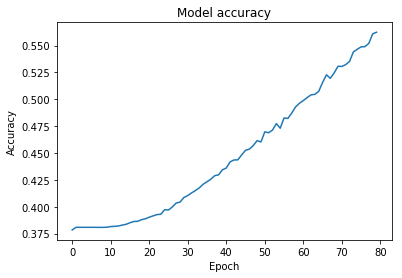

In [25]:
#plt.plot(history.history['acc'])
plt.plot(history_model.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [26]:
#predictions = model.predict(np.array(X_test), verbose=1)
predictions = mobilenetmodel.predict(np.array(X_test), verbose=1)


5073/5073 [==============================] - 53s 10ms/step


In [27]:
pred_df = copy.copy(train_df)
for i, pred in enumerate(predictions):
    pred_df.loc[i, 'Id'] = label_encoder.inverse_transform(pred.argsort()[-5:][::-1])

In [28]:
print(pred_df.head(10))


           Image                                                 Id
0  0000e88ab.jpg  [w_ae393cd, w_61b9586, w_c25d2d1, w_6e209a8, w...
1  0001f9222.jpg  [new_whale, w_43d4a64, w_00d50c9, w_c82b49f, w...
2  00029d126.jpg  [w_17b0d3a, w_f7cd240, w_90c9763, w_bc285a6, w...
3  00050a15a.jpg  [w_e5978cf, w_ab44ae4, w_9cc2c36, w_c3d896a, w...
4  0005c1ef8.jpg  [new_whale, w_5d6ba39, w_6ca173f, w_c3d896a, w...
5  0006e997e.jpg  [w_dd88965, w_5773c71, w_d875f4d, w_6071978, w...
6  000a6daec.jpg  [w_5793f1c, w_c55519c, w_2f74ff3, w_6f0cbe3, w...
7  000f0f2bf.jpg  [w_63b91aa, w_9b69214, w_5bf792a, w_0baf946, w...
8  0016b897a.jpg  [new_whale, w_72c56cc, w_7983f71, w_1b3baf7, w...
9  001c1ac5f.jpg  [w_f787e93, w_dc662ea, w_07768b0, w_5a9abcf, w...


### Evaluation of Prediction Precision

In [29]:
def map_per_image(label, predictions):
    """Computes the precision score of one image.

    Parameters
    ----------
    label : string
            The true label of the image
    predictions : list
            A list of predicted elements (order does matter, 5 predictions allowed per image)

    Returns
    -------
    score : double
    """   
    score = 0.0
    try:
        if not len(np.where(predictions == label)[0])==0:
            score =  1.0/(float(np.where(predictions == label)[0]) + 1)
            return score
        else:
            return 0.
            
    except ValueError:
        return 0.0

def map_per_set(labels, predictions):
    """Computes the average over multiple images.

    Parameters
    ----------
    labels : list
             A list of the true labels. (Only one true label per images allowed!)
    predictions : list of list
             A list of predicted elements (order does matter, 5 predictions allowed per image)

    Returns
    -------
    score : double
    """
    return np.mean([map_per_image(l, p) for l,p in zip(labels, predictions)])


In [30]:
totalaccuracy = 0.
totalaccuracy = map_per_set(train_df['Id'],pred_df['Id'])

In [31]:
print(totalaccuracy)

0.830962895785


### Create submission.csv (not in use for Udacity Capstone project, but created anyway)

In [32]:
#pred_df.to_csv('submission.csv', index=False)

### Predict for Testdata

In [33]:
test = os.listdir(datadir+"/test/")
print(len(test))

7960


In [34]:
col = ['Image']
test_df = pd.DataFrame(test, columns=col)
test_df['Id'] = ''

In [35]:
X = prepareImages(test_df, test_df.shape[0], "test")
X /= 255

Preparing images
('Processing image: ', 1, ', ', 'd25be2116.jpg')
('Processing image: ', 501, ', ', 'ecf335309.jpg')
('Processing image: ', 1001, ', ', '549ddf793.jpg')
('Processing image: ', 1501, ', ', '1459de372.jpg')
('Processing image: ', 2001, ', ', '59e6e5011.jpg')
('Processing image: ', 2501, ', ', 'f9293c32b.jpg')
('Processing image: ', 3001, ', ', '7fdc46c0e.jpg')
('Processing image: ', 3501, ', ', 'e0421d14a.jpg')
('Processing image: ', 4001, ', ', 'bc03470dc.jpg')
('Processing image: ', 4501, ', ', '48fa5169f.jpg')
('Processing image: ', 5001, ', ', 'b09d98273.jpg')
('Processing image: ', 5501, ', ', 'e6071c71f.jpg')
('Processing image: ', 6001, ', ', '9aefd155f.jpg')
('Processing image: ', 6501, ', ', 'cf91564b8.jpg')
('Processing image: ', 7001, ', ', '82f45e027.jpg')
('Processing image: ', 7501, ', ', '165c7bf64.jpg')


In [36]:
#predictions = model.predict(np.array(X), verbose=1)
predictions = model.predict(np.array(X), verbose=1)


7960/7960 [==============================] - 82s 10ms/step


In [37]:
for i, pred in enumerate(predictions):
    test_df.loc[i, 'Id'] = ' '.join(label_encoder.inverse_transform(pred.argsort()[-5:][::-1]))

In [38]:
test_df.head(10)
test_df.to_csv('submission.csv', index=False)